**PROJECT 2 : Dog Heart Vertebral Heart Size Point Detection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dog Heart Vertebral Heart Size Point Detection
# 1. Build an object detection model using pytorch

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d06cd38fd02402eeda6cc1eb52d26ce1c81718c374ad6d74d56ef10e6b24c66c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as Transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from efficientnet_pytorch import EfficientNet
from scipy.io import loadmat
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import csv

In [ ]:
#DogHeart images
class CustomDogDataset(object):
    def __init__(self, directory_path, transform_pipeline):
        self.directory_path = directory_path
        self.transform_pipeline = transform_pipeline
        self.image_files = sorted(os.listdir(os.path.join(directory_path, "Images")))
        self.label_files = sorted(os.listdir(os.path.join(directory_path, "Labels")))

    def __getitem__(self, index):
        image_path = os.path.join(self.directory_path, "Images", self.image_files[index])
        label_path = os.path.join(self.directory_path, "Labels", self.label_files[index])

        image = Image.open(image_path).convert("RGB")
        original_width, original_height = image.size

        if self.transform_pipeline is not None:
            image = self.transform_pipeline(image)

        resized_height, resized_width = image.shape[1], image.shape[2]

        mat_data = loadmat(label_path)
        points = mat_data['six_points'].astype(float)
        points = torch.tensor(points, dtype=torch.float32)
        points[:, 0] = resized_width / original_width * points[:, 0]
        points[:, 1] = resized_height / original_height * points[:, 1]
        points = points.flatten() / resized_height  # Normalize

        vhs_label = mat_data['VHS'].astype(float)
        vhs_label = torch.tensor(vhs_label, dtype=torch.float32)

        return image, points, vhs_label

    def __len__(self):
        return len(self.image_files)


In [ ]:
#transformations for training and testing
def build_transforms(img_size):
    return Transforms.Compose([
        Transforms.Resize((img_size, img_size)),
        Transforms.RandomHorizontalFlip(p=0.5),
        Transforms.RandomRotation(10),
        Transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        Transforms.ToTensor(),
        Transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])




In [ ]:
# EfficientNet-B7 model
class VHSNet(nn.Module):
    def __init__(self, pretrained=True):
        super(VHSNet, self).__init__()
        if pretrained:
            self.model = EfficientNet.from_pretrained('efficientnet-b7')
        else:
            self.model = EfficientNet.from_name('efficientnet-b7')

        num_features = self.model._fc.in_features
        self.model._fc = nn.Linear(num_features, 12)

    def forward(self, x):
        return self.model(x)

# Function to Calculate VHS
def calculate_vhs(points):
    dist_AB = np.linalg.norm(points[0] - points[1])
    dist_CD = np.linalg.norm(points[2] - points[3])
    dist_EF = np.linalg.norm(points[4] - points[5])
    vhs_value = 6 * (dist_AB + dist_CD) / dist_EF
    return vhs_value

# Custom Dataset for Test Images
class CustomTestDataset(Dataset):
    def __init__(self, path_to_data, transformations):
        self.path_to_data = path_to_data
        self.transformations = transformations
        self.image_list = sorted(os.listdir(os.path.join(path_to_data, "Images")))

    def __getitem__(self, idx):
        image_file = os.path.join(self.path_to_data, "Images", self.image_list[idx])
        img = Image.open(image_file).convert("RGB")
        original_w, original_h = img.size
        if self.transformations is not None:
            img = self.transformations(img)
        return img, self.image_list[idx], (original_w, original_h)

    def __len__(self):
        return len(self.image_list)


In [ ]:
# Train the Model
def train_model_v2(net, train_loader, valid_loader, loss_fn, optimizer, scheduler, epochs=40, model_save_path='model_v2.pth'):
    train_losses, valid_losses, valid_accs = [], [], []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        net.train()
        epoch_loss = 0.0

        for batch_images, batch_labels, _ in tqdm(train_loader):
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            preds = net(batch_images)
            loss = loss_fn(preds, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        net.eval()
        val_loss, correct_points, total_points = 0.0, 0, 0

        with torch.no_grad():
            for val_imgs, val_labels, _ in valid_loader:
                val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
                val_preds = net(val_imgs)
                loss = loss_fn(val_preds, val_labels)
                val_loss += loss.item()

                predicted_points = val_preds.cpu().numpy().reshape(-1, 2)
                true_points = val_labels.cpu().numpy().reshape(-1, 2)
                correct_points += np.sum(np.isclose(predicted_points, true_points, atol=5))
                total_points += true_points.size

        valid_losses.append(val_loss / len(valid_loader))
        accuracy = correct_points / total_points
        valid_accs.append(accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(net.state_dict(), model_save_path)

        if scheduler is not None:
            scheduler.step(val_loss)

    return train_losses, valid_losses, valid_accs


In [ ]:
# Prediction
def predict_and_save_vhs(net, test_data, resize, output_csv_path):
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
    results = []

    for img, img_name, original_dim in test_loader:
        img = img.to(device)
        with torch.no_grad():
            pred_coords = net(img).cpu().numpy().reshape(-1, 2)
        orig_w, orig_h = original_dim
        pred_coords[:, 0] = orig_w / resize * pred_coords[:, 0]
        pred_coords[:, 1] = orig_h / resize * pred_coords[:, 1]
        pred_vhs = calculate_vhs(pred_coords)
        results.append([img_name, pred_vhs])


    with open(output_csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(results)

In [ ]:
from torch.optim.lr_scheduler import StepLR

# device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
resize_val = 224
batch = 8
lr = 0.001
epochs = 100

# Data
train_data = CustomDogDataset('/content/drive/MyDrive/OneDrive_1_11-22-2024 (1)/Train', build_transforms(resize_val))
valid_data = CustomDogDataset('/content/drive/MyDrive/OneDrive_1_11-22-2024 (1)/Valid', build_transforms(resize_val))
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch, shuffle=False)

# Model
net = VHSNet(pretrained=True).to(device)
loss_fn = nn.MSELoss()
optim_fn = optim.Adam(net.parameters(), lr=lr)
lr_sched = StepLR(optim_fn, step_size=5, gamma=0.1)

# Model Training
train_loss, valid_loss, valid_acc = train_model_v2(
    net, train_loader, valid_loader, loss_fn, optim_fn, lr_sched, epochs, 'model_v2.pth'
)

# Save Final Model
torch.save(net.state_dict(), 'final_model_v2.pth')

#Training and Validation Losses
print("\nTraining and Validation Losses per Epoch:")
print("-" * 50)
for epoch, (t_loss, v_loss) in enumerate(zip(train_loss, valid_loss), 1):
    print(f"Epoch {epoch}: Training Loss = {t_loss:.4f}, Validation Loss = {v_loss:.4f}")

#Validation Accuracy
print("\nValidation Accuracy per Epoch:")
print("-" * 50)
for epoch, v_acc in enumerate(valid_acc, 1):
    print(f"Epoch {epoch}: Validation Accuracy = {v_acc:.4f}")


# Testing and VHS Calculation
test_data = CustomTestDataset('/content/drive/MyDrive/OneDrive_1_11-22-2024 (1)/Test_Images', build_transforms(resize_val))
predict_and_save_vhs(net, test_data, resize_val, 'test_results_v2.csv')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:02<00:00, 124MB/s]


Loaded pretrained weights for efficientnet-b7


100%|██████████| 175/175 [07:29<00:00,  2.57s/it]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 175/175 [01:06<00:00,  2.65it/s]



Training and Validation Losses per Epoch:
--------------------------------------------------
Epoch 1: Training Loss = 0.0298, Validation Loss = 0.0097
Epoch 2: Training Loss = 0.0039, Validation Loss = 0.0023
Epoch 3: Training Loss = 0.0031, Validation Loss = 0.0013
Epoch 4: Training Loss = 0.0023, Validation Loss = 0.0009
Epoch 5: Training Loss = 0.0021, Validation Loss = 0.0008
Epoch 6: Training Loss = 0.0017, Validation Loss = 0.0010
Epoch 7: Training Loss = 0.0016, Validation Loss = 0.0008
Epoch 8: Training Loss = 0.0015, Validation Loss = 0.0029
Epoch 9: Training Loss = 0.0015, Validation Loss = 0.0009
Epoch 10: Training Loss = 0.0013, Validation Loss = 0.0008
Epoch 11: Training Loss = 0.0011, Validation Loss = 0.0008
Epoch 12: Training Loss = 0.0011, Validation Loss = 0.0006
Epoch 13: Training Loss = 0.0010, Validation Loss = 0.0005
Epoch 14: Training Loss = 0.0010, Validation Loss = 0.0007
Epoch 15: Training Loss = 0.0009, Validation Loss = 0.0008
Epoch 16: Training Loss = 0.00

\\

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS



# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

In [ ]:
class Validation(Dataset):
    def __init__(self, root_directory, transform=None):
        self.root_directory = root_directory
        self.transform = transform

        self.image_files = sorted(os.listdir(os.path.join(root_directory, "Images")))
        self.label_files = sorted(os.listdir(os.path.join(root_directory, "Labels")))

    def __getitem__(self, index):
        img_path = os.path.join(self.root_directory, "Images", self.image_files[index])
        lbl_path = os.path.join(self.root_directory, "Labels", self.label_files[index])
        image = Image.open(img_path).convert("RGB")
        img_width, img_height = image.size

        if self.transform:
            image = self.transform(image)

        new_img_height, new_img_width = image.shape[1], image.shape[2]
        label_data = loadmat(lbl_path)
        keypoints = torch.tensor(label_data['six_points'], dtype=torch.float32)
        keypoints[:, 0] *= new_img_width / img_width
        keypoints[:, 1] *= new_img_height / img_height
        keypoints = keypoints.reshape(-1) / new_img_height
        vhs_value = torch.tensor(label_data['VHS'], dtype=torch.float32)

        return image, keypoints, vhs_value, self.image_files[index]

    def __len__(self):
        return len(self.image_files)




In [ ]:
# Plot Predictions and Ground Truths
def display_predictions(image, predicted_points, ground_truth_points, img_title, predicted_vhs, true_vhs):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)

    # Plot predicted and true points
    ax.scatter(predicted_points[:, 0], predicted_points[:, 1], c='r', s=50, label="Predicted")
    ax.scatter(ground_truth_points[:, 0], ground_truth_points[:, 1], c='g', s=50, label="Ground Truth")

    # Draw lines connecting points
    connections = [(0, 1), (2, 3), (4, 5)]
    for start, end in connections:
        ax.plot([predicted_points[start, 0], predicted_points[end, 0]],
                [predicted_points[start, 1], predicted_points[end, 1]], 'r--', linewidth=1)
        ax.plot([ground_truth_points[start, 0], ground_truth_points[end, 0]],
                [ground_truth_points[start, 1], ground_truth_points[end, 1]], 'g--', linewidth=1)

    ax.set_title(f"{img_title}\nPredicted VHS: {predicted_vhs:.2f}, True VHS: {true_vhs:.2f}")
    ax.axis("off")
    plt.legend()
    plt.show()


# Loading Model
def load_model(filepath):
    model = VHSNet()
    model.load_state_dict(torch.load(filepath))
    model = model.to(device)
    model.eval()
    return model





Loaded pretrained weights for efficientnet-b7


<ipython-input-47-ca3d3b4a37c1>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


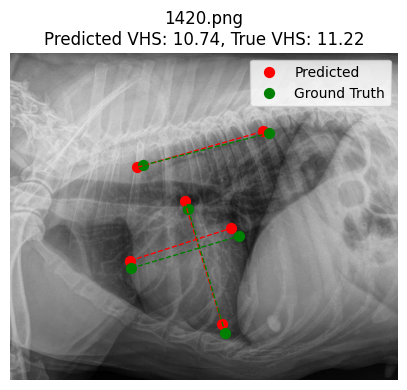

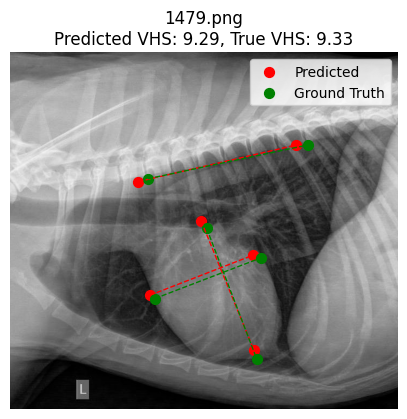

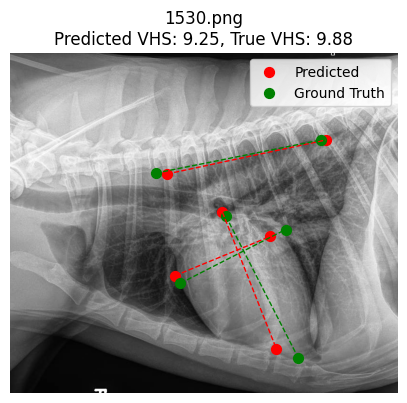

In [ ]:
# Validation Dataset and DataLoader
resize_dimension = 224
validation_data = Validation(
    '/content/drive/MyDrive/OneDrive_1_11-22-2024 (1)/Valid',
    build_transforms(resize_dimension)
)
validation_loader = DataLoader(validation_data, batch_size=1, shuffle=False)

# Images
comparison_images = ["1420.png", "1479.png", "1530.png"]

#Final Model
model = load_model('/content/final_model_v2.pth')


for img, true_keypoints, true_vhs, img_name in validation_loader:
    if img_name[0] in comparison_images:
        img_name = img_name[0]
        img = img.to(device)

        # Load Original Image for Dimensions
        original_img_path = os.path.join('/content/drive/MyDrive/OneDrive_1_11-22-2024 (1)/Valid/Images', img_name)
        original_img = Image.open(original_img_path).convert("RGB")
        img_width, img_height = original_img.size

        # Make Predictions
        with torch.no_grad():
            predicted_keypoints = model(img).cpu().numpy().reshape(-1, 2) * resize_dimension
        predicted_keypoints[:, 0] *= img_width / resize_dimension
        predicted_keypoints[:, 1] *= img_height / resize_dimension

        # Process Ground Truth
        true_keypoints = true_keypoints.cpu().numpy().reshape(-1, 2) * resize_dimension
        true_keypoints[:, 0] *= img_width / resize_dimension
        true_keypoints[:, 1] *= img_height / resize_dimension

        # Calculate VHS
        predicted_vhs = calculate_vhs(predicted_keypoints)
        true_vhs = true_vhs.item()

        # Convert Image to NumPy for Visualization
        original_img_np = np.array(original_img)

        # Visualize Results
        display_predictions(original_img_np, predicted_keypoints, true_keypoints, img_name, predicted_vhs, true_vhs)


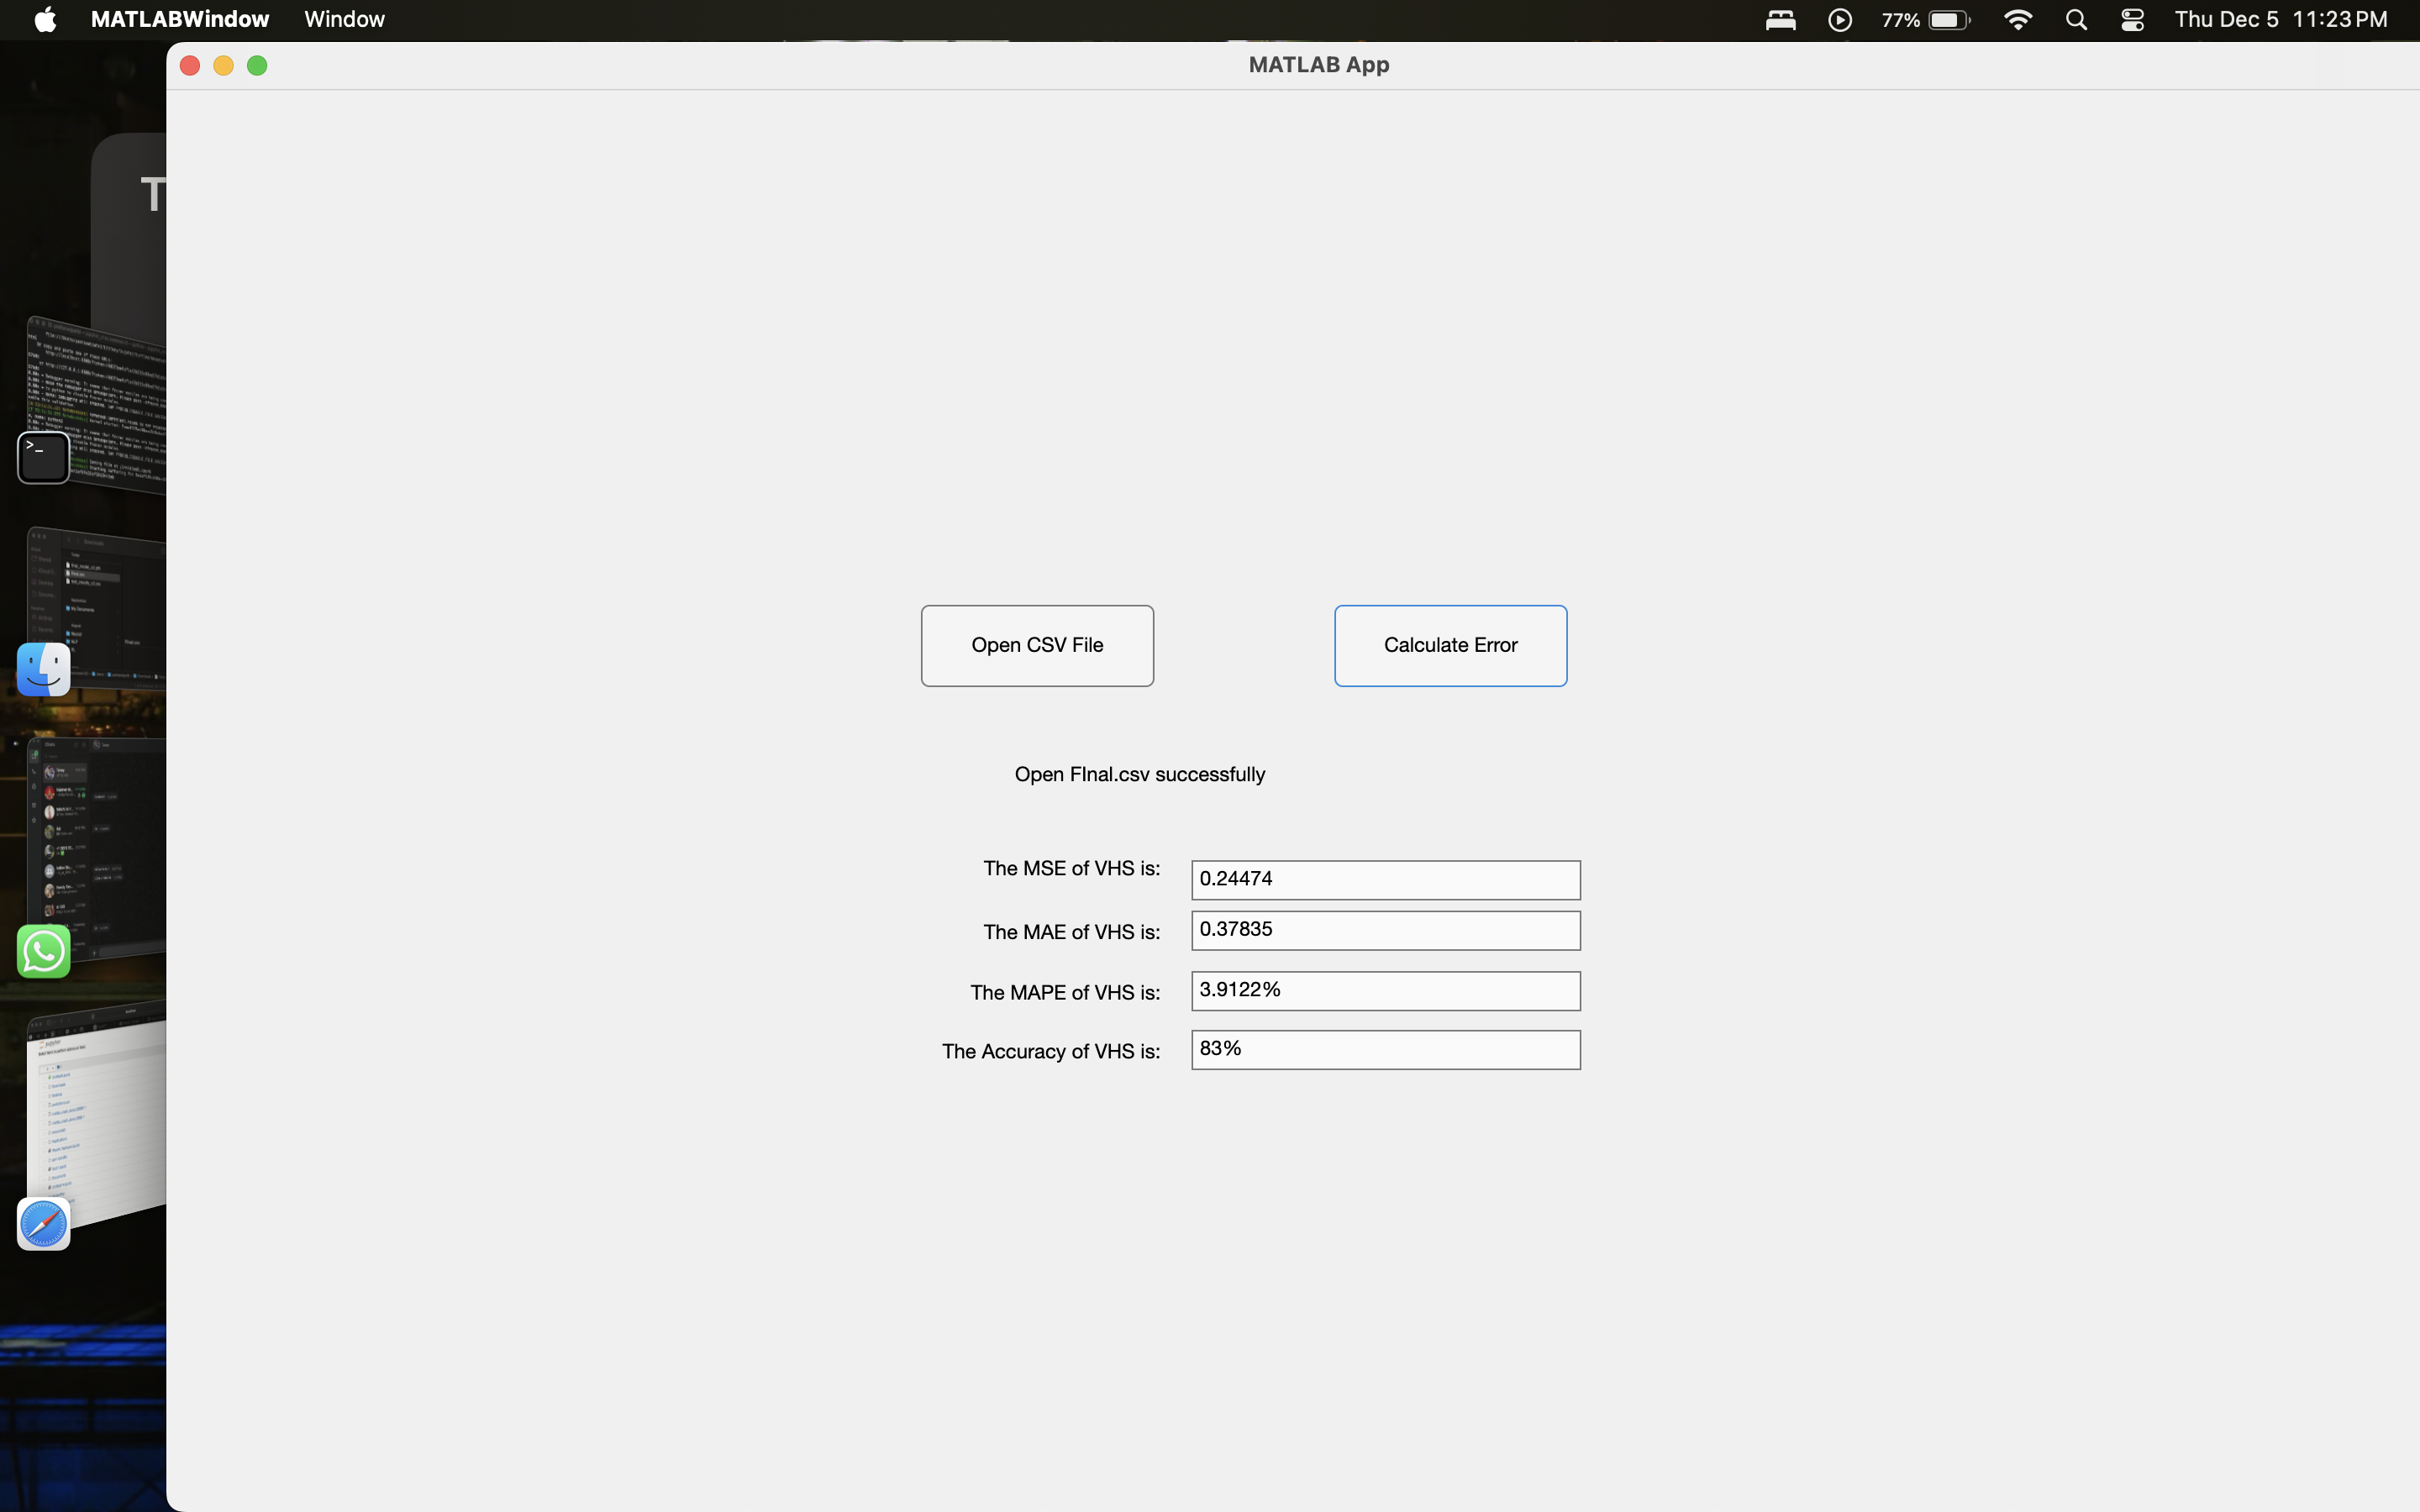

# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


In [ ]:
https://www.researchgate.net/publication/386466350_Dog_Heart_Vertebral_Heart_Size_Point_Detection

# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)